In [ ]:
import os
os.environ["keras_backend"] = "tensorflow"

In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [1]:
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Input
from keras.layers import Conv1D
from keras.layers.convolutional import AtrousConvolution1D
from keras.models import Sequential
import itertools
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import timeit
%matplotlib inline



C:\local\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load data

In [2]:
data=np.load('overnight_all_compressed.npz')
eval_data = data['arr_2']

Load train data from zip file and merge all files in to single array

In [3]:
#x = np.load('overnight_all_compressed_new.npz')
#print(x)
#x_t=[]
final_array=np.array([])

a = data['arr_0']
b = data['arr_1']

print(a.shape)
print(b.shape)


final_array=np.vstack([a,b])

print(final_array.shape)

"""for i in x:
    
    print(x[i].shape)
    temp=x[i]
    final_array = np.hstack()
    final_array = np.concatenate((final_array,temp),axis=0)"""
    #np.concatenate(p,x[i])
    #p =np.concatenate((p,temp),axis=0)
    #np.append(x[i])
    
#data=['seconds','mic (trachea)','abdominal movement (stretch sensor)','thorax movement (stretch sensor)']
#x = pd.DataFrame(x['arr_0'], columns = data)
#x = pd.DataFrame(x['arr_1'], columns = data)

#merged = list(itertools.chain.from_iterable(x_t))


(11044514, 4)
(4769867, 4)
(15814381, 4)


'for i in x:\n    \n    print(x[i].shape)\n    temp=x[i]\n    final_array = np.hstack()\n    final_array = np.concatenate((final_array,temp),axis=0)'

Divide data into X & Y sets for the train and validation data

In [27]:
X_train = final_array[:,1]
Y_train = final_array[:,2]

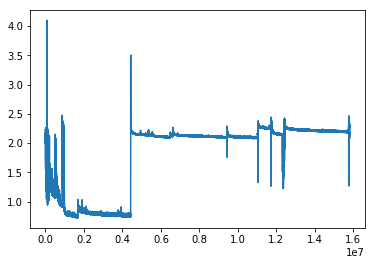

In [5]:
plt.plot(Y_train)

Differencing the target variable - abdominal stretch movement

In [ ]:
new_column = np.zeros([final_array.shape[0],1])
diff_array=np.hstack([final_array,new_column])
diff_array[1:,4]=np.diff(diff_array[:,2],axis=0)
plt.plot(diff_array[:,4])

manual median filter

In [ ]:
def median_filter(x, n):    
    
    for i in range(n//2, len(x)-n-n//2):
        x[i+n//2,4] = np.median(x[i:i+n])
    return x

Applying median filter and time taken to calculate filter values

In [ ]:
start=timeit.default_timer()
median_array=median_filter(diff_array,3)
stop=timeit.default_timer()
print(stop-start)
plt.plot(median_array[:,4])

CumSum of the above median filtered data

In [ ]:
median_array[:,4]=np.cumsum(median_array[:,4],axis=0)

plt.plot(median_array[:,4])

define X & Y train data

In [ ]:
X_train=median_array[:,1]
Y_train=median_array[:,4]

In [ ]:
print(Y_train.shape)

removing offset spikes using differencing followed by scipy median filter & cumsum

In [6]:
Y_train_diff=Y_train
Y_train_diff[1:]=np.diff(Y_train)
print(Y_train_diff.shape)
median_array_func=Y_train_diff
start=timeit.default_timer()
median_array_func=scipy.signal.medfilt(Y_train_diff,3)
print(median_array_func.shape)

stop=timeit.default_timer()
print(stop-start)
Y_train_final=np.cumsum(median_array_func)
print(Y_train_final.shape)



(15814381,)
(15814381,)
2.7448939
(15814381,)


In [7]:
Y_train=Y_train_final

Unseen Eval data divided in to X & Y for prediction & testing

In [8]:
time=eval_data[:1000000,0]
x_pred=eval_data[:1000000,5].reshape(1000000,1,1)
y_true=eval_data[:1000000,2]

model 1 with 1D Convolution layers and final dense/FC layer with filter of size 1,1,1

In [9]:
def Conv_test():
    model = Sequential()
    model.add(Convolution1D(32,1,border_mode='same',activation='relu'))
    model.add(Convolution1D(16,1,border_mode='same',activation='relu'))
    model.add(Convolution1D(2,1,border_mode='same',activation='relu'))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    return model

modified 1D CNN with dilation rate & final linear dense layer to linearise the output of the abdomen movement

In [10]:
def CausalConv_test():
    model = Sequential()    
    model.add(Conv1D(64,3,padding='same',activation='relu',dilation_rate=1, input_shape=(1000,1)))
    model.add(Conv1D(16,1,padding='same',dilation_rate=2,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=4,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=8,activation='relu'))

    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [11]:
def CausalConv_test2():
    model = Sequential()    
    model.add(Conv1D(64,3,padding='same',activation='relu',dilation_rate=1, input_shape=(1000,1)))
    model.add(Conv1D(16,1,padding='same',dilation_rate=2,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=4,activation='relu'))
    model.add(Conv1D(2,1,padding='same',dilation_rate=8,activation='relu'))

    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model 2 with 1D Convolution layers and final dense/FC layer with filter of size 3, 1, 1

In [12]:
def Conv1D_test():
    model = Sequential()    
    model.add(Conv1D(64,3,padding='same',activation='relu', input_shape=(1000,1)))
    model.add(Conv1D(16,1,padding='same',activation='relu'))
    model.add(Conv1D(2,1,padding='same',activation='relu'))
    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
def Dilated_Conv():
    model = Sequential()    
    model.add(AtrousConvolution1D(64,3,padding='same',activation='relu',atrous_rate=1, input_shape=(1000,1)))
    model.add(AtrousConvolution1D(16,1,padding='same',atrous_rate=2,activation='relu'))
    model.add(AtrousConvolution1D(2,1,padding='same',atrous_rate=4,activation='relu'))
    model.add(Dense(4,activation='tanh'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

#keras.layers.convolutional.AtrousConvolution1D(nb_filter, filter_length, init='glorot_uniform', activation=None, weights=None, border_mode='valid', subsample_length=1, atrous_rate=1, W_regularizer=None, b_regularizer=None, activity_regularizer=None, W_constraint=None, b_constraint=None, bias=True)

Split train data into train and validation using scikit method

In [14]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_train,Y_train, test_size=0.33)

In [15]:
print(Y_train.shape)
print(X_train.shape)
print(median_array_func.shape)


(15814381,)
(15814381,)
(15814381,)


manually splitting train data  into train (70%) and validation (30% )

In [28]:
l= len(X_train)
Xtrain = X_train[:round(l*0.7)]
Xtest = X_train[round(l*0.7)+1:]
ytrain = Y_train[:round(l*0.7)]
ytest = Y_train[round(l*0.7)+1:]

Reshape the train & test into batches to train the model

In [29]:
window_size = 1000
leftover = len(Xtrain)%window_size

X_reshaped_train=(Xtrain[:-leftover]).reshape(-1,window_size,1)
print(X_reshaped_train.shape)

y_reshaped_train=(ytrain[:-leftover]).reshape(-1,window_size,1)

leftover_test = len(Xtest)%window_size

X_reshaped_test=(Xtest[:-leftover_test]).reshape(-1,window_size,1)
y_reshaped_test=(ytest[:-leftover_test]).reshape(-1,window_size,1)



(11070, 1000, 1)


In [30]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


# Xtrain=(Xtrain).reshape(len(Xtrain),1,1)

# ytrain=ytrain.reshape(len(ytrain),1,1)

# Xtest=Xtest.reshape(len(Xtest),1,1)

# ytest=ytest.reshape(len(ytest),1,1)

validationData=(Xtest,ytest)
'''
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)'''
print(Xtrain.shape)

model=Dilated_Conv()
history = model.fit(X_reshaped_train,y_reshaped_train,
                    validation_data=(X_reshaped_test, y_reshaped_test),
                    epochs=10,batch_size=50,
                    callbacks=[early_stopping])

(11070067,)


C:\local\Anaconda3\lib\site-packages\keras\legacy\layers.py:288: UserWarning: The `AtrousConvolution1D` layer  has been deprecated. Use instead the `Conv1D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution1D` layer '


Train on 11070 samples, validate on 4744 samples
Epoch 1/10
11070/11070 [==============================] - 529s 48ms/step - loss: 3.9506e-05 - val_loss: 2.9572e-05
Epoch 2/10
11070/11070 [==============================] - 528s 48ms/step - loss: 1.9147e-05 - val_loss: 2.9570e-05
Epoch 3/10
11070/11070 [==============================] - 527s 48ms/step - loss: 1.9145e-05 - val_loss: 2.9569e-05
Epoch 4/10
11070/11070 [==============================] - 525s 47ms/step - loss: 1.9144e-05 - val_loss: 2.9569e-05
Epoch 5/10
11070/11070 [==============================] - 524s 47ms/step - loss: 1.9144e-05 - val_loss: 2.9568e-05
Epoch 6/10
11070/11070 [==============================] - 533s 48ms/step - loss: 1.9144e-05 - val_loss: 2.9568e-05
Epoch 7/10
11070/11070 [==============================] - 533s 48ms/step - loss: 1.9143e-05 - val_loss: 2.9568e-05
Epoch 8/10
11070/11070 [==============================] - 527s 48ms/step - loss: 1.9143e-05 - val_loss: 2.9568e-05
Epoch 9/10
11070/11070 [=======

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


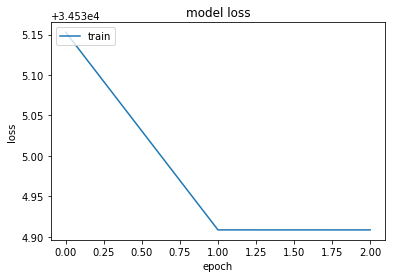

In [21]:
print(history.history.keys())
#y_pred=model.predict(x_pred)
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
x_reshaped_pred= x_pred.reshape(-1,window_size,1)

In [23]:
print(x.shape)

NameError: name 'x' is not defined

In [24]:
y_pred=model.predict(X_reshaped_train)
y_pred_unravel=y_pred.reshape(-1,1)
print(y_pred_unravel.shape)

(11070000, 1)


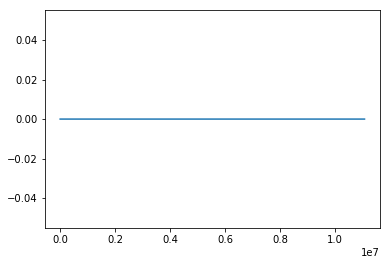

In [25]:
plt.plot(y_pred_unravel)

(11070, 1000, 1)
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


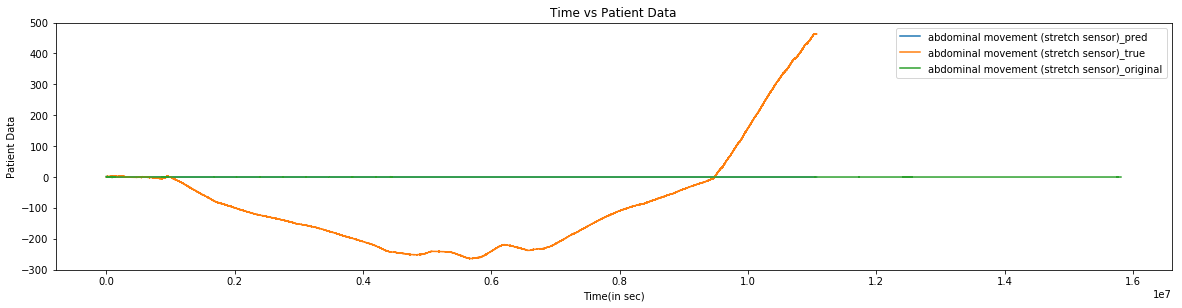

In [26]:
y_pred=model.predict(X_reshaped_train)
y_pred.reshape(-1,1)
print(y_pred.shape)
y_pred= y_pred.reshape(-1,1)
print(y_pred)
fig = plt.figure(figsize=(20,10))
#for ix,items in zip([1,2],x):
ax = fig.add_subplot(2,1,1)
ax.set_title('Time vs Patient Data')
ax.set_xlabel('Time(in sec)')
ax.set_ylabel('Patient Data')
ax.plot(y_pred,label='abdominal movement (stretch sensor)_pred')
ax.plot(y_reshaped_train.reshape(-1,1),label='abdominal movement (stretch sensor)_true')
ax.plot(final_array[:,2],label='abdominal movement (stretch sensor)_original')




ax.legend()


In [ ]:


y_pred=model.predict(x_reshaped_pred)
print(y_pred.shape)
y_pred= y_pred.reshape(-1,1)
fig = plt.figure(figsize=(20,10))
#for ix,items in zip([1,2],x):
ax = fig.add_subplot(2,1,1)
ax.set_title('Time vs Patient Data')
ax.set_xlabel('Time(in sec)')
ax.set_ylabel('Patient Data')
ax.plot(time,y_pred,label='abdominal movement (stretch sensor)_pred')
ax.plot(time,y_true,label='abdominal movement (stretch sensor)_true')



ax.legend()


In [ ]:
# note: try differencing, median filtering and cumsum to remove offset spikes